#### 1. Data collection & exploration

The datasets used in the project were discovered and collected using the information from an open source eye disease data table [$^{[1]}$](https://www.thelancet.com/journals/landig/article/PIIS2589-7500(20)30240-5/fulltext). From the table, only 2 datasets (ACRIMA & Kaggle cataract datasets) had fundus photographies which present glaucoma. 

In [18]:
import matplotlib.pyplot as plt  # to visualize images
import numpy as np
import os                        # to get images paths & create new folders
import shutil                    # to move images
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
# Get the current working directory
current_dir = os.getcwd()

##### 1.1. ACRIMA dataset
* **Country:** Spain 
* **No. of patients:** unknown
* **No. of images:** 705 
* **Diseases present:** Glaucoma and healthy eyes
* **Instrument used:** TRC retina camera (Topcon, Japan)
* **Image format:** JPEG

> ACRIMA database is composed by 705 fundus images (396 glaucomatous and 309 normal images). They were collected at the FISABIO Oftalmología Médica in Valencia, Spain, from glaucomatous and normal patients with their previous consent and in accordance with the ethical standards laid down in the 1964 Declaration of Helsinki. All images from ACRIMA database were annotated by glaucoma experts with several years of experience. They were cropped around the optic disc and renamed. 

> The image name has the following structure: First, the name starts with the two letters "Im", followed by an image number composed by three digits (starting from 001 until 705), followed by the label (this label is "_g_" if the image is pathological and "_" if the image is normal). Finally, all image names have the database name, "ACRIMA", at the end of their names. For example, a name for a glaucomatous image is "Im686_g_ACRIMA" and "Im001_ACRIMA" for a normal image.

In [3]:
# Create new directories to separate the glaucoma & non-glaucoma datasets
acrima_dir = current_dir + "/data/acrima-dataset"
glaucoma_dir = acrima_dir + "/glaucoma"
normal_dir = acrima_dir + "/normal"

# Ensure directories do not overwrite previous ones
if os.path.isdir(glaucoma_dir) == False:
    os.makedirs(glaucoma_dir)
if os.path.isdir(normal_dir) == False:
    os.makedirs(normal_dir)

In [4]:
# Move the images to the new directories
acrima_images = os.listdir(acrima_dir)

# Move the images to the glaucoma vs normal folders
for image_name in acrima_images:
    image_path = acrima_dir + "/" + image_name
    if "_g_" in image_name:
        shutil.move(image_path, glaucoma_dir)
    elif image_path not in [glaucoma_dir, normal_dir]:
        shutil.move(image_path, normal_dir)

normal_images = os.listdir(normal_dir)
glaucoma_images = os.listdir(glaucoma_dir)

# Look at the number of samples in each dataset
print(f"There are {len(glaucoma_images)} images representing an eye with glaucoma")
print(f"There are {len(normal_images)} images representing a normal eye")

There are 396 images representing an eye with glaucoma
There are 309 images representing a normal eye


Sample glaucoma images:


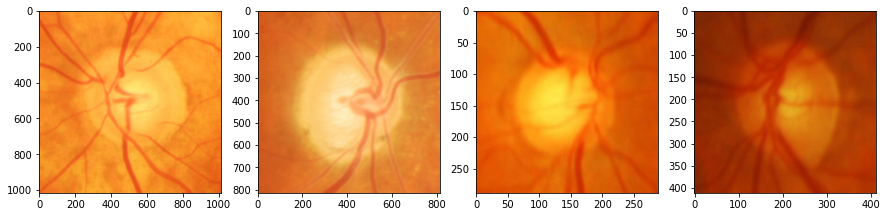


Sample normal images:


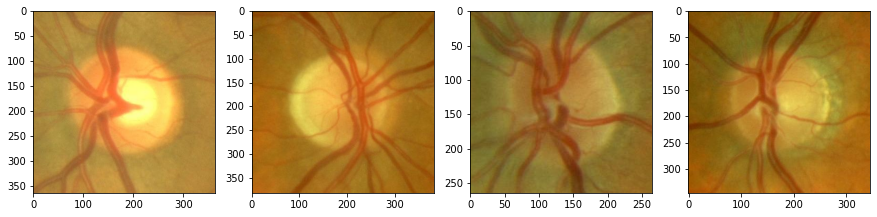

In [5]:
# Look at sample images in each dataset
print("Sample glaucoma images:")
plt.subplots(figsize=(15, 10))
for i in range(1, 5):
    plt.subplot(1, 4, i)
    plt.imshow(load_img(f"{os.path.join(glaucoma_dir, glaucoma_images[i - 1])}"))
plt.show()

print("\nSample normal images:")
plt.subplots(figsize=(15, 10))
for i in range(1, 5):
    plt.subplot(1, 4, i)
    plt.imshow(load_img(f"{os.path.join(normal_dir, normal_images[i - 1])}"))
plt.show()

We notice that the first pictures are RGB, have equal height & width, but vary a lot in overall size. This is especially true for the glaucoma dataset, whereas in the normal dataset the image size for the first images stays roughly around 300 x 300 pixels.

In [10]:
# Get the image shapes from directories
def get_image_sizes(directory):
    image_sizes = []
    image_paths = [x for x in os.listdir(directory) if \
        os.path.isdir(os.path.join(directory, x)) == False]
    for path in image_paths:
        image = load_img(f"{os.path.join(directory, path)}")
        image_array = img_to_array(image)
        image_sizes.append(image_array.shape)
    return image_sizes

In [11]:
# Check the variation in image size across the two datasets
glaucoma_size = get_image_sizes(glaucoma_dir)
normal_size = get_image_sizes(normal_dir)

print(f"The largest image in the glaucoma dataset has {max(glaucoma_size)} size")
print(f"The largest image in the normal dataset has {max(normal_size)} size")
print("\n")
print(f"The smallest image in the glaucoma dataset has {min(glaucoma_size)} size")
print(f"The smallest image in the normal dataset has {min(normal_size)} size")

The largest image in the glaucoma dataset has (1420, 1420, 3) size
The largest image in the normal dataset has (652, 652, 3) size


The smallest image in the glaucoma dataset has (178, 178, 3) size
The smallest image in the normal dataset has (265, 265, 3) size


We see there is quite a lot of variability in the image sizes for the ACRIMA dataset, but that they're all RGB images with equal height & width. We will deal with the varying image sizes in the [image processing & augmentation]() section.

In [12]:
# Get the maximum pixel value from a given directory of images
def get_max_pixel(directory):
    max_pixel_value = 0
    image_paths = [x for x in os.listdir(directory) if \
        os.path.isdir(os.path.join(directory, x)) == False]
    for path in image_paths:
        image = load_img(f"{os.path.join(directory, path)}")
        image_array = img_to_array(image)
        if max_pixel_value < np.max(image_array):
            max_pixel_value = np.max(image_array)
    return max_pixel_value

In [13]:
# Check the maximum pixel value
g_max_pixel = get_max_pixel(glaucoma_dir)
n_max_pixel = get_max_pixel(normal_dir)

print(f"The maximum pixel value in the glaucoma directory is {g_max_pixel}")
print(f"The maximum pixel value in the normal directory is {n_max_pixel}")

The maximum pixel value in the glaucoma directory is 255.0
The maximum pixel value in the normal directory is 255.0


Given the maximum pixel value is 255 in both datasets, this means we need to normalize the training set pixel values by 255.

##### 1.2. Kaggle cataract detection dataset

* **Country:** unknown 
* **No. of patients:** unknown
* **No. of images:** 601 
* **Diseases present:** Glaucoma, cataracts, retinal diseases and healthy eyes
* **Instrument used:** unknown
* **Image format:** PNG

We'll follow a similar exploration procedure for the Kaggle dataset.

In [14]:
kaggle_dir = current_dir + "/data/kaggle-dataset"
glaucoma_dir = kaggle_dir + "/3_glaucoma"
normal_dir = kaggle_dir + "/1_normal"

normal_images = os.listdir(normal_dir)
glaucoma_images = os.listdir(glaucoma_dir)

# Look at the number of samples in each dataset
print(f"There are {len(glaucoma_images)} images representing an eye with glaucoma")
print(f"There are {len(normal_images)} images representing a normal eye")

There are 101 images representing an eye with glaucoma
There are 300 images representing a normal eye


Given the Kaggle dataset is much smaller and more imbalanced than the ACRIMA dataset, we can keep it for validation & testing.

Sample glaucoma images:


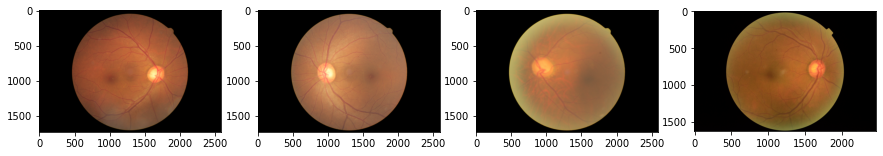


Sample normal images:


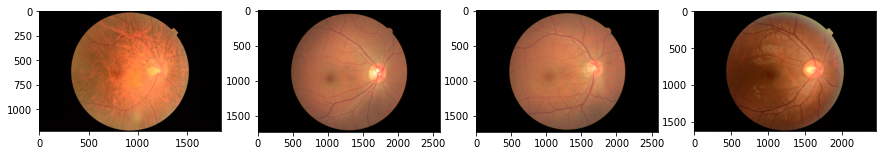

In [15]:
# Look at sample images in each dataset
print("Sample glaucoma images:")
plt.subplots(figsize=(15, 10))
for i in range(1, 5):
    plt.subplot(1, 4, i)
    plt.imshow(load_img(f"{os.path.join(glaucoma_dir, glaucoma_images[i - 1])}"))
plt.show()

print("\nSample normal images:")
plt.subplots(figsize=(15, 10))
for i in range(1, 5):
    plt.subplot(1, 4, i)
    plt.imshow(load_img(f"{os.path.join(normal_dir, normal_images[i - 1])}"))
plt.show()

At first glance, we notice the images in the Kaggle dataset have a much higher resolution and include the whole eye fundus image as opposed to a section of it.

In [16]:
# Check the variation in image size across the two datasets
glaucoma_size = get_image_sizes(glaucoma_dir)
normal_size = get_image_sizes(normal_dir)

print(f"The largest image in the glaucoma dataset has {max(glaucoma_size)} size")
print(f"The largest image in the normal dataset has {max(normal_size)} size")
print("\n")
print(f"The smallest image in the glaucoma dataset has {min(glaucoma_size)} size")
print(f"The smallest image in the normal dataset has {min(normal_size)} size")

The largest image in the glaucoma dataset has (1728, 2592, 3) size
The largest image in the normal dataset has (1728, 2592, 3) size


The smallest image in the glaucoma dataset has (1224, 1848, 3) size
The smallest image in the normal dataset has (1224, 1848, 3) size


There is also plenty of variation in image size in the Kaggle datasets, although these are similar in the normal & glaucoma datasets, as opposed to the ACRIMA datasets. Additionally, all images have a much higher resolution than the ones in the ACRIMA dataset.

In [17]:
# Check the maximum pixel value
g_max_pixel = get_max_pixel(glaucoma_dir)
n_max_pixel = get_max_pixel(normal_dir)

print(f"The maximum pixel value in the glaucoma directory is {g_max_pixel}")
print(f"The maximum pixel value in the normal directory is {n_max_pixel}")

The maximum pixel value in the glaucoma directory is 255.0
The maximum pixel value in the normal directory is 255.0
